使用resnet18模型，操作相对简单，先导入包

In [1]:
# !pip install d2l

import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import d2l
from torch import nn
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import torchvision
import os
import shutil
import numpy as np
import pandas as pd
import csv
import torchvision.models as models

net模型是教材上的原版，训练精确度第一次是0.9，model是resnet18模型

In [2]:
import torch
from torch import nn
from torch.nn import functional as F  # 导入函数库
from d2l import torch as d2l  # 导入d2l模块，d2l是Dive into Deep Learning的缩写

class Residual(nn.Module):  # 定义一个继承自nn.Module的类
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):  # 初始化函数
        super().__init__()  # 调用基类的初始化函数
        # 定义第一个卷积层，输入通道数为input_channels，输出通道数为num_channels
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        # 定义第二个卷积层，输入通道数和输出通道数都是num_channels
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        # 根据use_1x1conv的布尔值决定是否使用1x1的卷积层
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        # 定义两个批量归一化层
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        # 定义ReLU激活函数，inplace=True表示原地操作，节省内存
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, X):  # 前向传播函数
        # 应用第一个卷积层和批量归一化层，然后使用ReLU激活函数
        Y = self.relu(self.bn1(self.conv1(X)))
        # 应用第二个卷积层和批量归一化层
        Y = self.bn2(self.conv2(Y))
        # 如果定义了1x1的卷积层，则应用它
        if self.conv3:
            X = self.conv3(X)
        # 将输入X和经过卷积和批量归一化的Y相加
        Y += X
        # 再次应用ReLU激活函数并返回结果
        return self.relu(Y)
    
# ResNet的第一个stage
b1 = nn.Sequential(nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
                  nn.BatchNorm2d(64),nn.ReLU(),
                  nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

# class Residual为小block，resnet_block 为大block，为Resnet网络的一个stage
def resnet_block(input_channels,num_channels,num_residuals,first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block: # stage中不是第一个block则高宽减半
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True,strides=2))   
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b2 = nn.Sequential(*resnet_block(64,64,2,first_block=True)) # 因为b1做了两次宽高减半，nn.Conv2d、nn.MaxPool2d，所以b2中的首次就不减半了      
b3 = nn.Sequential(*resnet_block(64,128,2)) # b3、b4、b5的首次卷积层都减半
b4 = nn.Sequential(*resnet_block(128,256,2))
b5 = nn.Sequential(*resnet_block(256,512,2))

net = nn.Sequential(b1,b2,b3,b4,b5,nn.AdaptiveAvgPool2d((1,1)),nn.Flatten(),nn.Linear(512,10))    

c:\Users\18368\.conda\envs\autogluon\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\18368\.conda\envs\autogluon\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# 读取训练数据集
labels_dataframe = pd.read_csv('./01_data/classify-leaves/train.csv')
# 获取所有标签
leaves_labels = sorted(list(set(labels_dataframe['label'])))
print('leaves_labels: ',leaves_labels)
# 获取标签数量
n_classes = len(leaves_labels)
print('n_classes: ',n_classes)
# 将标签转换为数字
class_to_num = dict(zip(leaves_labels, range(n_classes)))
print('zip(leaves_labels, range(n_classes)): ',zip(leaves_labels, range(n_classes)))

print('class_to_num: ',class_to_num)

# 将数字转换为标签
num_to_class = {v : k for k, v in class_to_num.items()}
print('num_to_class: ',num_to_class)

# 读取 csv 文件
# 利用pandas读取csv文件
valid_ratio = 0.2
data_info = pd.read_csv('./01_data/classify-leaves/train.csv', header=None)  #header=None是去掉表头部分
# 计算 length
data_len = len(data_info.index) - 1
print('data_len: ',data_len)
train_len = int(data_len * valid_ratio)-1
print('train_len: ',train_len)

leaves_labels:  ['abies_concolor', 'abies_nordmanniana', 'acer_campestre', 'acer_ginnala', 'acer_griseum', 'acer_negundo', 'acer_palmatum', 'acer_pensylvanicum', 'acer_platanoides', 'acer_pseudoplatanus', 'acer_rubrum', 'acer_saccharinum', 'acer_saccharum', 'aesculus_flava', 'aesculus_glabra', 'aesculus_hippocastamon', 'aesculus_pavi', 'ailanthus_altissima', 'albizia_julibrissin', 'amelanchier_arborea', 'amelanchier_canadensis', 'amelanchier_laevis', 'asimina_triloba', 'betula_alleghaniensis', 'betula_jacqemontii', 'betula_lenta', 'betula_nigra', 'betula_populifolia', 'broussonettia_papyrifera', 'carpinus_betulus', 'carpinus_caroliniana', 'carya_cordiformis', 'carya_glabra', 'carya_ovata', 'carya_tomentosa', 'castanea_dentata', 'catalpa_bignonioides', 'catalpa_speciosa', 'cedrus_atlantica', 'cedrus_deodara', 'cedrus_libani', 'celtis_occidentalis', 'celtis_tenuifolia', 'cercidiphyllum_japonicum', 'cercis_canadensis', 'chamaecyparis_pisifera', 'chamaecyparis_thyoides', 'chionanthus_retus

对csv图片预处理，并且使用k作为折数，0.2是取的数据集一部分用于测试，并且添加了一些参数，并在kaggle上训练

In [3]:
# 读取训练数据集
labels_dataframe = pd.read_csv('./01_data/classify-leaves/train.csv')
# 获取所有标签
leaves_labels = sorted(list(set(labels_dataframe['label'])))
# 获取标签数量
n_classes = len(leaves_labels)
# 生成以字典形式存储标签和数字之间的映射关系"标签为键，数字为值"
class_to_num = dict(zip(leaves_labels, range(n_classes)))
# 数字为键，标签为值:字典中的键值对进行交换
num_to_class = {v : k for k, v in class_to_num.items()}

# 继承pytorch的dataset，创建自己的
class LeavesData(Dataset):
    def __init__(self, csv_path, file_path, k=0, mode='train', valid_ratio=0.2, resize_height=256, resize_width=256):
        """
        Args:
            csv_path (string): csv 文件路径
            img_path (string): 图像文件所在路径
            mode (string): 训练模式还是测试模式
            valid_ratio (float): 验证集比例
        """
        
        # 需要调整后的照片尺寸，我这里每张图片的大小尺寸不一致#
        self.resize_height = resize_height
        self.resize_width = resize_width

        self.file_path = file_path
        self.k=k
        self.mode = mode

        # 读取 csv 文件
        # 利用pandas读取csv文件
        self.data_info = pd.read_csv(csv_path, header=None)  #header=None是去掉表头部分
        # 计算 length
        self.data_len = len(self.data_info.index) - 1
        self.train_len = int(self.data_len * valid_ratio)-1
        
        
        if mode == 'train':
            # np.asarray 用于将输入数据转换为 NumPy 数组
            # concat 用于将多个数组或张量（tensor）沿着指定的轴连接在一起
            # iloc 是 Pandas 库中的一个函数，用于基于整数位置进行数据选择。
            # 第一列包含图像文件的名称,self.data_info.iloc[1:,0]表示读取第一列，从第二行开始到train_len
            self.train_image = np.asarray(pd.concat([self.data_info.iloc[1:self.k*self.train_len, 0],
                                                     self.data_info.iloc[1+(self.k+1)*self.train_len:, 0]]))  
            # 第二列是图像的 label
            self.train_label = np.asarray(pd.concat([self.data_info.iloc[1:self.k*self.train_len, 1],
                                                     self.data_info.iloc[1+(self.k+1)*self.train_len:, 1]]))  
            self.image_arr = self.train_image 
            self.label_arr = self.train_label
        elif mode == 'valid':
            self.valid_image = np.asarray(self.data_info.iloc[1+self.k*self.train_len:1+(self.k+1)*self.train_len, 0])  
            self.valid_label = np.asarray(self.data_info.iloc[1+self.k*self.train_len:1+(self.k+1)*self.train_len, 1])
            self.image_arr = self.valid_image
            self.label_arr = self.valid_label
        elif mode == 'test':
            self.test_image = np.asarray(self.data_info.iloc[1:, 0])
            self.image_arr = self.test_image
            
        self.real_len = len(self.image_arr)

        print('Finished reading the {} set of Leaves Dataset ({} samples found)'
              .format(mode, self.real_len))

    def __getitem__(self, index):
        # 从 image_arr中得到索引对应的文件名
        single_image_name = self.image_arr[index]

        # 读取图像文件
        img_as_img = Image.open(self.file_path + single_image_name)

        #如果需要将RGB三通道的图片转换成灰度图片可参考下面两行
#         if img_as_img.mode != 'L':
#             img_as_img = img_as_img.convert('L')

        #设置好需要转换的变量，还可以包括一系列的nomarlize等等操作
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),   #随机水平翻转 选择一个概率
                transforms.RandomVerticalFlip(p=0.5),
                transforms.ToTensor()
            ])
        else:
            # valid和test不做数据增强
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])
        
        img_as_img = transform(img_as_img)
        
        if self.mode == 'test':
            return img_as_img
        else:
            # 得到图像的 string label
            label = self.label_arr[index]
            # number label
            number_label = class_to_num[label]

            return img_as_img, number_label  #返回每一个index对应的图片数据和对应的label

    def __len__(self):
        return self.real_len
    
num_epochs = 10
batch_size=16
lr=0.05
    
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

if torch.cuda.is_available():
    torch.cuda.init()
    print('GPU available')
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # 将模型移动到设备上（如GPU）

train_path = './01_data/classify-leaves/train.csv'
test_path = './01_data/classify-leaves/test.csv'
# csv文件中已经images的路径了，因此这里只到上一级目录
img_path = './01_data/classify-leaves/'

GPU available


定义训练函数，i是循环使用折数k折交叉验证，目前训练25轮

In [12]:
from d2l import torch as d2l

def train_ch_def(net, num_epochs, lr, device):
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    net = net.to(device)
    
    for i in range(2):
        train_dataset = LeavesData(train_path, img_path,k=i,mode='train')
        val_dataset = LeavesData(train_path, img_path, k=i,mode='valid')

        train_iter = DataLoader(dataset=train_dataset,batch_size=batch_size, shuffle=True)#表示随机洗牌读数
        val_iter = DataLoader(dataset=val_dataset,batch_size=batch_size, shuffle=True)
        legend = ['train loss','train_acc', 'val loss', 'val acc']
        animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend)

        for epoch in range(num_epochs):
            net.train()
            train_loss, train_acc, n = 0.0, 0.0, 0
            for X, y in train_iter:
                X = X.to(device)
                y = y.to(device)
                optimizer.zero_grad()
                y_hat = net(X)
                l = loss(y_hat, y)
                l.backward()
                optimizer.step()
                train_loss += l.item() * y.shape[0]
                train_acc += (y_hat.argmax(dim=1) == y).sum().item()
                n += y.shape[0]

            net.eval()
            val_loss, val_acc, m = 0.0, 0.0, 0
            for X, y in val_iter:
                X = X.to(device)
                y = y.to(device)
                with torch.no_grad():
                    y_hat = net(X)
                    l = loss(y_hat, y)
                    val_loss += l.item() * y.shape[0]
                    val_acc += (y_hat.argmax(dim=1) == y).sum().item()
                    m += y.shape[0]

            train_loss /= n
            train_acc /= n
            val_loss /= m
            val_acc /= m

            animator.add(epoch + 1, (train_loss, train_acc, val_loss, val_acc))


            print(f"Epoch {i+1}.{epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

训练完成后保存模型

Epoch 2.15: Train Loss=0.0195, Train Acc=0.9922, Val Loss=0.0297, Val Acc=0.9853


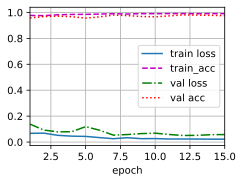

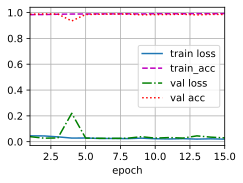

In [13]:
train_ch_def(model, num_epochs, lr, device)
torch.save(model.state_dict(), './01_data/classify-leaves/resnet18.pth')

复制输出文件到working文件夹里

In [14]:
import shutil

# 定义源文件路径和目标路径
source_file = './01_data/classify-leaves/submission.csv'
destination_folder = './kaggle/working/submission.csv'

# 使用shutil.copy()函数复制文件
shutil.copy(source_file, destination_folder)

'./kaggle/working/submission.csv'

加载模型进行测试，并且把文件输出到csv提交文件里

In [15]:
model.load_state_dict(torch.load('./01_data/classify-leaves/resnet18.pth'))
model.eval()  # 设置模型为评估模式

test_path = './01_data/classify-leaves/test.csv'
# csv文件中已经images的路径了，因此这里只到上一级目录
img_path = './01_data/classify-leaves/'

test_dataset = LeavesData(test_path, img_path, k=0,mode='test')
test_iter = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 将模型移动到设备
model.to(device)

csv_file = './01_data/classify-leaves/submission.csv'
num=0

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image', 'label'])  # 写入表头

for images in test_iter:
    # 对图像进行预处理
    images = images.to(device)
    outputs = model(images)
    # 获取预测结果
    _, predicted = torch.max(outputs, 1)

    # 打印预测结果
    #print(num_to_class[predicted])
    class_predictions = [num_to_class[i.item()] for i in predicted]
    
    # 将列表元素按行写入CSV文件
    with open(csv_file, 'a', newline='') as file:
        writer = csv.writer(file)
        if file.tell() == 0:  # 检查文件是否为空
            writer.writerow(['image', 'label'])  # 写入表头
        for index,element in enumerate(class_predictions):
            writer.writerow([f'images/{18353+index+num}.jpg', element])
    num+=batch_size


print("列表元素已写入CSV文件：", csv_file)

Finished reading the test set of Leaves Dataset (8800 samples found)
列表元素已写入CSV文件： ./01_data/classify-leaves/submission.csv


查看预测结果

In [9]:
predict=pd.read_csv('./01_data/classify-leaves/submission.csv')
predict

,image,label
0,images/18353.jpg,asimina_triloba
1,images/18354.jpg,betula_nigra
2,images/18355.jpg,platanus_acerifolia
3,images/18356.jpg,pinus_bungeana
4,images/18357.jpg,platanus_acerifolia
...,...,...
8795,images/27148.jpg,pinus_thunbergii
8796,images/27149.jpg,crataegus_crus-galli
8797,images/27150.jpg,pinus_thunbergii
8798,images/27151.jpg,juniperus_virginiana
